In [26]:
import os
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, ReLU, Dropout
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from keras.utils import plot_model
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [27]:
K.clear_session()

In [28]:
from tensorflow.keras.datasets import mnist
# load dataset
(trainX, trainy), (testX, testy) = mnist.load_data()

trainX=trainX/255
testX=testX/255

# summarize loaded dataset
print('Train: X=%s, y=%s' % (trainX.shape, trainy.shape))
print('Test: X=%s, y=%s' % (testX.shape, testy.shape))

Train: X=(60000, 28, 28), y=(60000,)
Test: X=(10000, 28, 28), y=(10000,)


In [52]:
def step_decay(epoch):

    initial_lrate=0.001
    step_size=10
    decay_factor=0.5
    new_lr=initial_lrate * (decay_factor ** np.floor(epoch/step_size))
    print(new_lr,epoch)
    return new_lr

class AutoEncoder():

    _ENC_FILTERS = [32,64,64,64]
    _ENC_STRIDES = [1,2,2,1]
    _FILTER_SIZE = [3,3,3,3]
    _LATENT_SPACE = 32
    _DEC_FILTERS = [64,64,32,1]
    _DEC_STRIDES = [1,2,2,1]
    _BATCH_NORM = True
    _DROPOUT = 0.2

    def __init__(self,input_dim, latent_space):

        self.input_dim = input_dim
        self.latent = latent_space

    def _build_encoder(self):

        encoder_input = Input(shape=self.input_dim,name='encoder_input')
        x=encoder_input

        for lyr in range(len(self._ENC_FILTERS)):

            conv_layer = Conv2D(filters = self._ENC_FILTERS[lyr],
                              kernel_size = self._FILTER_SIZE[lyr],
                              strides = self._ENC_STRIDES[lyr],
                              name = 'encoder_conv'+str(lyr),
                              padding ='same')
            x = conv_layer(x)
            x = ReLU()(x)

            if self._BATCH_NORM == True:
                x = BatchNormalization()(x)

        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)
        encoder_output = Dense(self.latent, name = 'encoder_output')(x)
        encoder = Model(encoder_input, encoder_output, name = 'Encoder')

        return encoder

    def _build_decoder(self,shape_before_flattening):

        decoder_input = Input(shape = self.latent,name = 'decoder_input')
        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for lyr in range(len(self._DEC_FILTERS)):

            conv_t_layer = Conv2DTranspose(filters = self._DEC_FILTERS[lyr],
                                         kernel_size = self._FILTER_SIZE[lyr],
                                         strides=self._DEC_STRIDES[lyr],
                                         name = 'decoder_conv_t'+str(lyr),
                                         padding = 'same')
            x = conv_t_layer(x)

            if lyr<len(self._DEC_FILTERS)-1:

                x = ReLU()(x)

                if self._BATCH_NORM == True:
                    x = BatchNormalization()(x)
            else:
                x=Activation('sigmoid')(x)

        decoder_output = x
        decoder = Model(decoder_input,decoder_output, name = 'Decoder')
        return decoder

    def fit(self,Xtr,Xval,**kwargs):

        self.initial_lr = kwargs.get("initial_lr", 0.001)
        self.batch_size = kwargs.get("batch_size", 32)
        self.callbacks_list = kwargs.get("callbacks_list", [])
        self.epochs = kwargs.get("epochs", 100)
        self.shuffle = kwargs.get("shuffle", True)

        model, decoder, encoder = self.get_model()

        model.fit(Xtr, Xtr,
                       batch_size = self.batch_size,
                       validation_data = (Xval,Xval),
                       shuffle = self.shuffle,
                       epochs = self.epochs,
                       callbacks = self.callbacks_list)

        self.model = model
        self.decoder = decoder
        self.encoder = encoder


    def get_model(self):

        #Autoencoder Layer
        encoder = self._build_encoder()
        shape_before_flattening = encoder.layers[-5].get_output_at(0).get_shape().as_list()[1:]
        decoder = self._build_decoder(shape_before_flattening)

        model_input = Input(shape=self.input_dim,name = 'encoder_input')
        encoder_op = encoder(model_input)
        decoder_op = decoder(encoder_op)

        model = Model(model_input,decoder_op,name = 'ae_model')

        model.compile(optimizer = Adam(learning_rate  = 0.001),
                           loss = 'mean_squared_error')

        return model, decoder, encoder

In [53]:
ae = AutoEncoder(input_dim=(28,28,1), latent_space = 16)
model, decoder, encoder = ae.get_model()
model.summary()

Model: "ae_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        (None, 16)                143760    
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         146561    
                                                                 
Total params: 290,321
Trainable params: 289,553
Non-trainable params: 768
_________________________________________________________________


In [54]:
early_stopper = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10)
callbacks_list=[early_stopper]
ae.fit(trainX,testX, epochs = 10, batch_szie = 16)

Epoch 1/10
1875/1875 [==============================] - 19s 10ms/step - loss: 0.0173 - val_loss: 0.0112
Epoch 2/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0090 - val_loss: 0.0081
Epoch 3/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0080 - val_loss: 0.0083
Epoch 4/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0075 - val_loss: 0.0076
Epoch 5/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0071 - val_loss: 0.0072
Epoch 6/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0068 - val_loss: 0.0068
Epoch 7/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 8/10
1875/1875 [==============================] - 16s 9ms/step - loss: 0.0064 - val_loss: 0.0064
Epoch 9/10
1875/1875 [==============================] - 17s 9ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 10/10
1875/1875 [==============================] - 17s 9ms/step - 

1/1 [==============================] - 0s 42ms/step


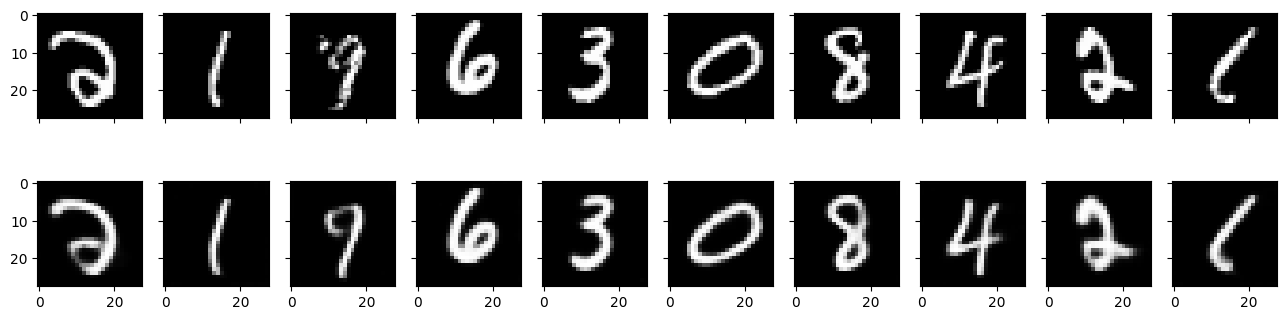

In [73]:
samples = np.random.randint(0,testX.shape[0],10)
testX_recons = ae.model.predict(testX[samples])

fig,axn=plt.subplots(2,10,sharex='col',sharey='row',figsize=(16,4))
for n,i in enumerate(samples):
    axn[0,n].imshow(testX[i], cmap = 'gray')
    axn[1,n].imshow(testX_recons[n],cmap = 'gray')